# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       17379 non-null  int64  
 1   season      17379 non-null  object 
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 2.0+ MB
None
            index            yr          mnth            hr       holiday  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000 

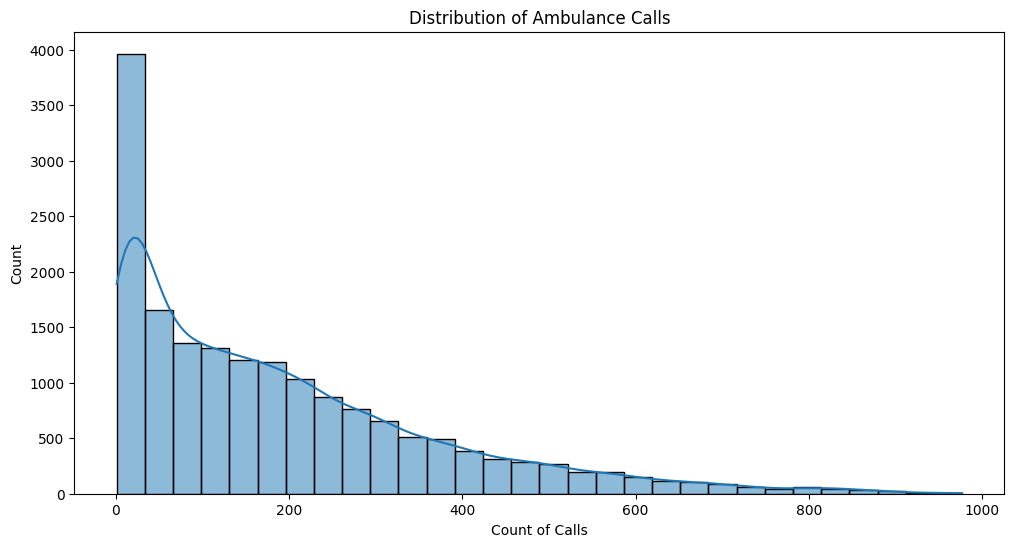

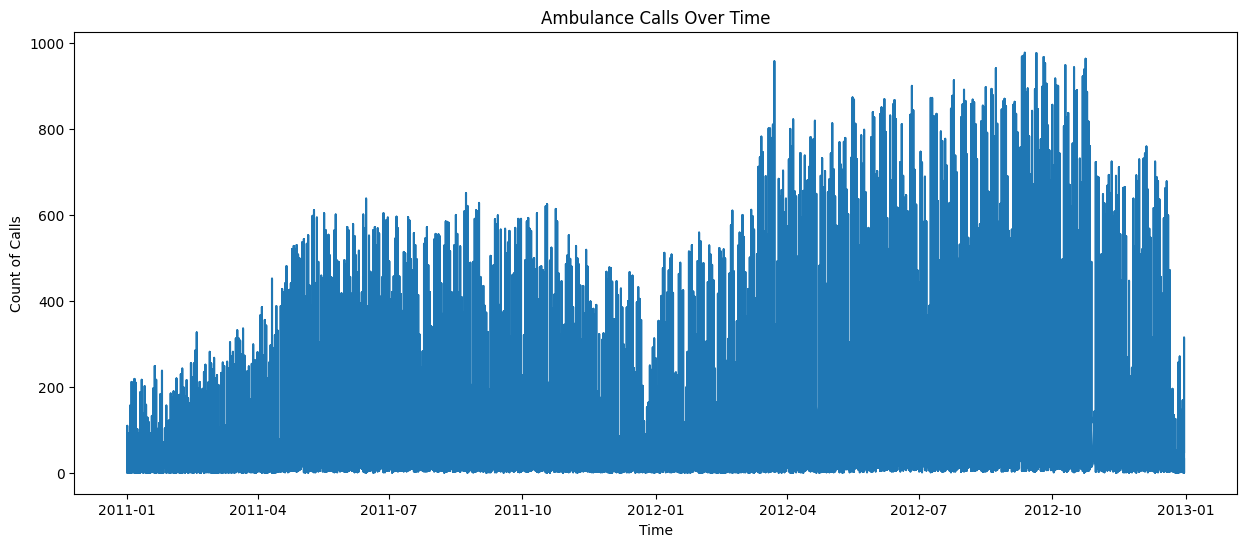

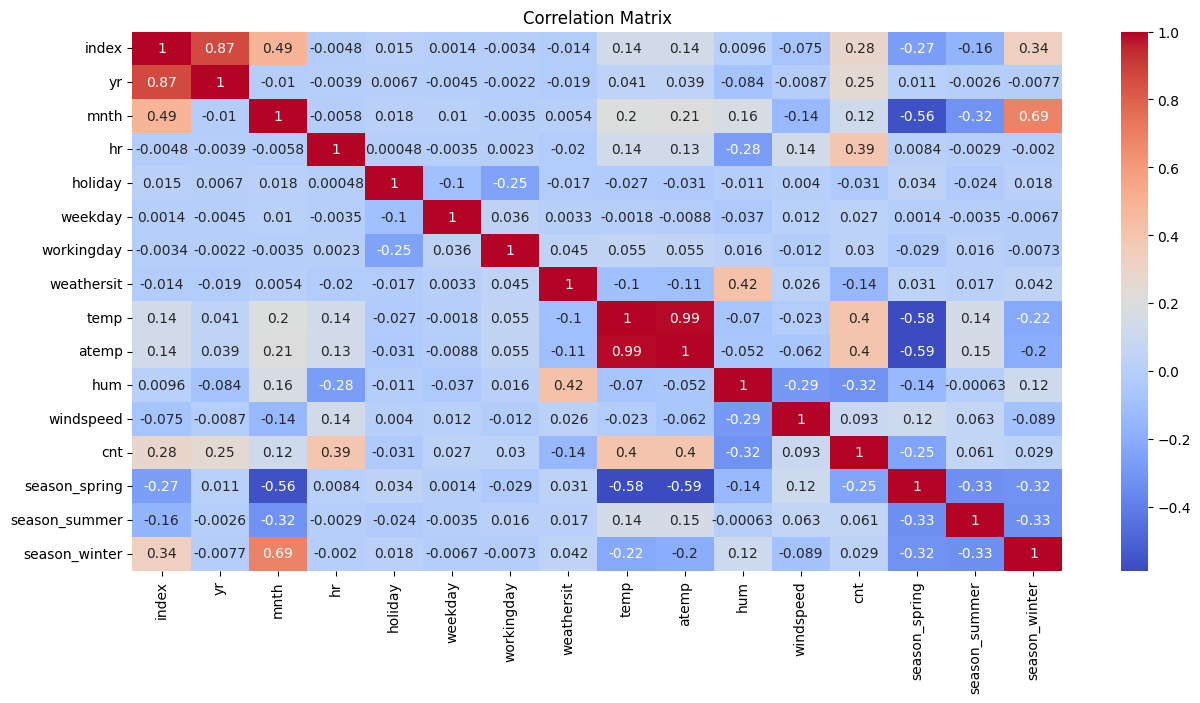

In [12]:
data = pd.read_csv('motorbike_ambulance_calls.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

print(data.info())
print(data.describe())

data = pd.get_dummies(data, drop_first=True)

plt.figure(figsize=(12, 6))
sns.histplot(data['cnt'], bins=30, kde=True)
plt.title('Distribution of Ambulance Calls')
plt.xlabel('Count of Calls')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(data['cnt'])
plt.title('Ambulance Calls Over Time')
plt.xlabel('Time')
plt.ylabel('Count of Calls')
plt.show()

plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
data['day'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year
data['hour'] = data['hr'] if 'hr' in data.columns else None 

print("Columns in dataset:", data.columns)

categorical_cols = ['season', 'weathersit', 'weekday']
for col in categorical_cols:
    if col in data.columns:
        data = pd.get_dummies(data, columns=[col], drop_first=True)
    else:
        print(f"Column '{col}' not found in dataset.")

columns_to_drop = ['index', 'mnth', 'hr']
data.drop([col for col in columns_to_drop if col in data.columns], axis=1, inplace=True)

Columns in dataset: Index(['index', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'season_spring', 'season_summer', 'season_winter', 'day', 'month',
       'year', 'hour'],
      dtype='object')
Column 'season' not found in dataset.


In [ ]:
X = data.drop('cnt', axis=1)
y = data['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Mean Squared Error: 1730.349152387802


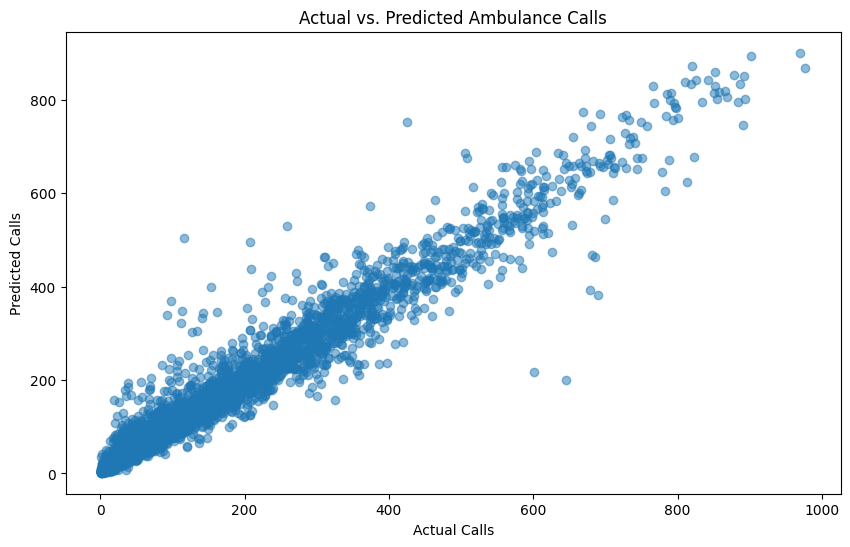

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Calls')
plt.ylabel('Predicted Calls')
plt.title('Actual vs. Predicted Ambulance Calls')
plt.show()


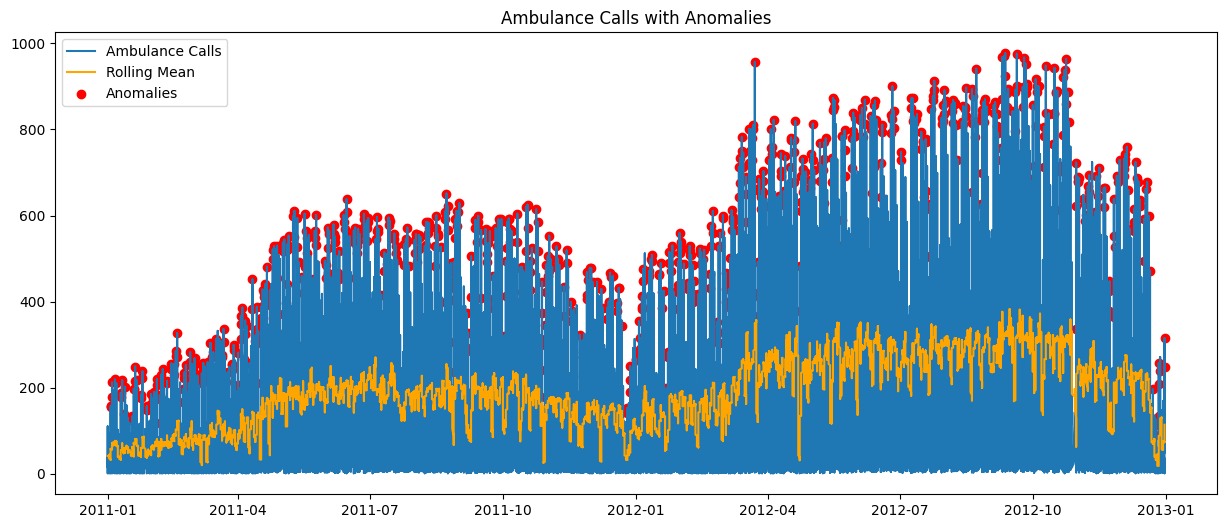

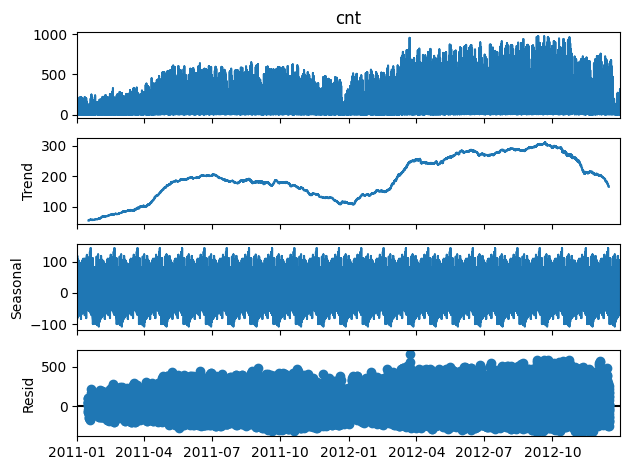

In [ ]:
data['rolling_mean'] = data['cnt'].rolling(window=24).mean()
data['rolling_std'] = data['cnt'].rolling(window=24).std()

data['anomaly'] = (data['cnt'] > data['rolling_mean'] + 2 * data['rolling_std']) | \
                  (data['cnt'] < data['rolling_mean'] - 2 * data['rolling_std'])

plt.figure(figsize=(15, 6))
plt.plot(data['cnt'], label='Ambulance Calls')
plt.plot(data['rolling_mean'], color='orange', label='Rolling Mean')
plt.scatter(data[data['anomaly']].index, data[data['anomaly']]['cnt'], color='red', label='Anomalies')
plt.legend()
plt.title('Ambulance Calls with Anomalies')
plt.show()

result = seasonal_decompose(data['cnt'], model='additive', period=24*30)
result.plot()
plt.show()


1. Datetime Conversion & Indexing: Converted date to datetime and set as index.
	Reason: Essential for time-series analysis and operations.

	Feature Engineering: Added day, month, year, hour features.
	Reason: Captures time-based patterns and trends.

	Categorical Encoding: Used pd.get_dummies() for categorical variables.
	Reason: Machine learning models require numerical data.

	Data Cleaning: Dropped unnecessary columns.
	Reason: Reduces noise and simplifies the dataset.

	EDA & Visualization: Created histograms, time series, and correlation plots.
	Reason: Provides insights into data distribution and feature relationships.

	Data Scaling: Standardized features with StandardScaler.
	Reason: Ensures all features are treated equally by the model.

	Model Training: Trained RandomForestRegressor, evaluated with MSE.
	Reason: Random Forest is robust for non-linear relationships, MSE measures prediction accuracy.

2. 		
	Preprocessing: Encoded categorical columns, removed irrelevant ones, and added time-based features (day, month, year, hour).
	EDA: Visualized cnt distribution and time series to identify patterns. Created a correlation heatmap to find relationships between features.

	Data Splitting & Scaling: Split data into training/testing sets and standardized features using StandardScaler for better model performance. 

	Model Training: Trained a RandomForestRegressor, evaluated with Mean Squared Error, and compared actual vs. predicted calls to assess accuracy. 

	Anomaly Detection: Used rolling mean and standard deviation to flag outliers as potential anomalies.

	Seasonality Decomposition: Analyzed trend, seasonality, and residuals in cnt to understand time-based patterns.

3.  Introduction The goal is to predict ambulance call volumes and detect anomalies to optimize emergency response. 

	Data Preprocessing Converted date to datetime, encoded categorical variables, and added time-based features. 
		
	3EDA Visualized the distribution of calls and trends over time; explored feature correlations. 

	Model Training Scaled data and trained a Random Forest model, evaluated using Mean Squared Error (MSE).

 	Anomaly Detection Flagged anomalies using a rolling mean and standard deviation, highlighting outliers.

  	Seasonality Decomposition Separated the data into trend, seasonal, and residual components for deeper insights.

4. Advanced Models: Try XGBoost or LSTM for better predictions.

	Feature Engineering: Add holidays or events; use lag features.

	Anomaly Detection: Use Isolation Forest or Autoencoders.

	Time-Series Forecasting: Apply ARIMA or Prophet for future predictions.
	
	Real-time Forecasting: Build a dynamic system for resource allocation.